In [1]:
import sys
sys.path.append('../')

from util import *
import matplotlib.pyplot as plt

from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression

In [2]:
PATH = './data/SensorLogger/'
FILENAME = 'data.csv'
SAMPLE_FREQ = 200

In [3]:
data = load_all_data(PATH, FILENAME)

Loading: 100%|██████████| 26/26 [00:36<00:00,  1.42s/it]


In [4]:
X = 1/data['pedal_seconds']
y = data['Location_speed']

m = np.logical_and(np.logical_not(np.isnan(X)), np.logical_not(np.isnan(y)))
m = np.logical_and(m, np.logical_and(np.logical_and(X > 0.5, X < 1.5), y < 10))

X = np.array(X)[m]
y = np.array(y)[m]

In [22]:
rem = np.full_like(X, True, dtype=bool)
models = []
epsilon = 0.425

for i in tqdm(range(8)):
    r = RANSACRegressor(base_estimator=LinearRegression(fit_intercept=False), residual_threshold=epsilon, max_trials=1000, stop_probability=0.999)
    r.fit(X[rem].reshape(-1, 1), y[rem].reshape(-1, 1))
    rem = np.logical_and(rem, np.abs(r.predict(X.reshape(-1, 1)).flatten() - y) > epsilon)
    models.append(r)

100%|██████████| 8/8 [00:16<00:00,  2.11s/it]


In [ ]:
# Reduntant, but pretty

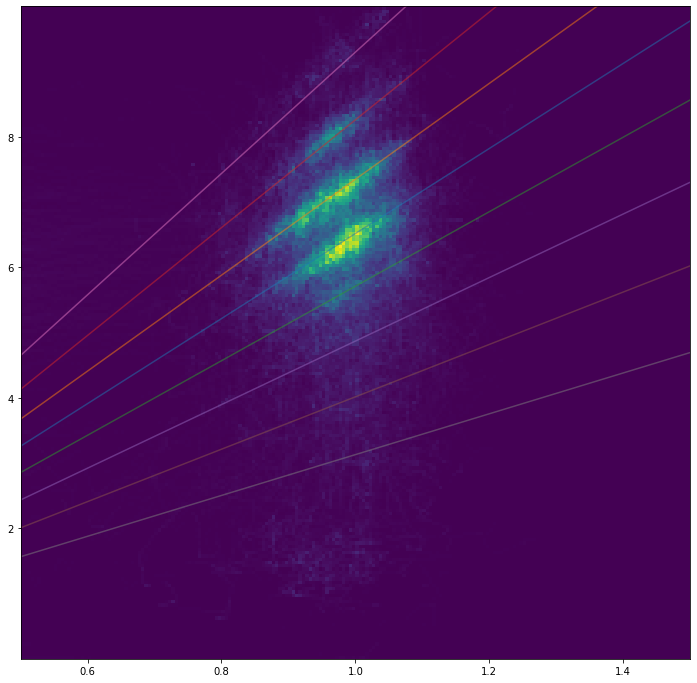

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# ax.hist2d(X[rem], y[rem], bins=100);
ax.hist2d(X, y, bins=200);
for r in models:
    ax.plot(np.linspace(0, 2.5, 100), r.predict(np.linspace(0, 2.5, 100).reshape(-1, 1)), alpha=0.5)

# ax.plot(np.linspace(0, 2.5, 100), np.linspace(0, 2.5, 100)*9.5, alpha=0.5);

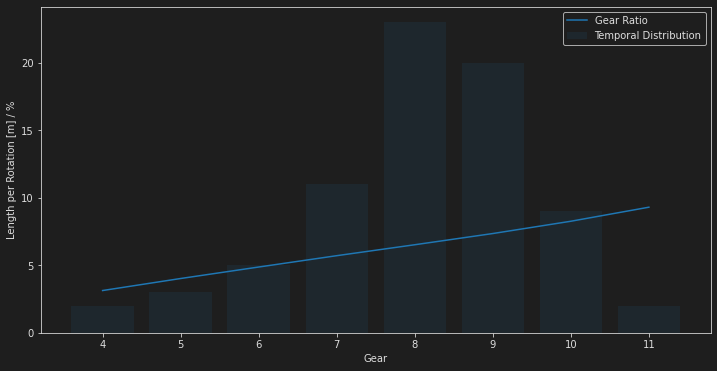

In [57]:
# length [m] per full pedal rotation
gears = np.arange(4, 12)
ratios = np.array([r.estimator_.coef_ for r in models]).flatten()
ord = np.argsort(ratios)
n_inliers = np.array([np.sum(r.inlier_mask_)/len(data) for r in models]).flatten()[ord].round(2)
ratios = ratios[ord].round(2)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(gears, ratios, label='Gear Ratio'); ax.bar(gears, n_inliers * 100, alpha=0.1, label='Temporal Distribution'); ax.legend(); ax.set_xlabel('Gear'); ax.set_ylabel('Length per Rotation [m] / %');

In [56]:
print(f'Distance [m] in first Gear:  {LinearRegression().fit(gears.reshape(-1, 1), ratios).predict([[1]])[0].round(3)}')
print(f'Extra Distance [m] per Gear: {LinearRegression().fit(gears.reshape(-1, 1), ratios).coef_[0].round(3)}')

Distance [m] in first Gear:  0.524
Extra Distance [m] per Gear: 0.865


In [43]:
np.vstack([gears, ratios, n_inliers]).T

array([[ 4.  ,  3.13,  0.02],
       [ 5.  ,  4.02,  0.03],
       [ 6.  ,  4.87,  0.05],
       [ 7.  ,  5.71,  0.11],
       [ 8.  ,  6.52,  0.23],
       [ 9.  ,  7.35,  0.2 ],
       [10.  ,  8.26,  0.09],
       [11.  ,  9.3 ,  0.02]])